In [5]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm, logm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian

# Bose-Hubbard Model

In [9]:
params = {
    'N': 21, # no. of sites
    't':1.0,
    'T': 20,
    'tau': 0.01
}

In [10]:
params['dim'] = 0
params['occupationTuple_lst'] = []
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}
params['N'], params['k'], params['mu'], params['U'] = 2, 2, 0.4, 1
def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = sp.csc_matrix(np.zeros(N))
    pass

dimension(params)
# print(params['vac'])

In [11]:
def normalizeWF(psi,**kwargs):
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF


In [12]:
params['N'], params['k'], params['mu'], params['U'] = 3, 1, 0.3, 1
params['truncationParam_n'] = 2
def creationOpMatrix(params, **kwargs):
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), -1)
    return A
# A = creationOpMatrix(params)
# print(A)
def annihilationOpMatrix(params, **kwargs):
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), 1)
    return A
# B = annihilationOpMatrix(params)
def numOpMatrix(params, site_no, **kwargs):
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    I = sp.identity(params['truncationParam_n']+1)
    lst = [I for _ in range(params['N'])]
    if 'tilt' in kwargs:
        lst[site_no] = nOp*site_no
        matrx = sp.csc_matrix(reduce(sp.kron, lst))
        return matrx
    else: 
        lst[site_no] = nOp
        matrix1 = sp.csc_matrix(reduce(sp.kron, lst))
        lst[site_no] = nOp@nOp
        matrix2 = sp.csc_matrix(reduce(sp.kron, lst))
        return matrix1, matrix2
# print(numOpMatrix(params, 1, tilt = True))
def HoppingOpMatrix(params, site_no, **kwargs):
    n, N = params['truncationParam_n'], params['N']
    matrixx = sp.csc_matrix(((n+1)**N, (n+1)**N))
    if site_no != params['N']-1:
        creationOp, annihOp = creationOpMatrix(params), annihilationOpMatrix(params)
        I = sp.identity(params['truncationParam_n']+1)
        lst = [I for _ in range(params['N'])]
        lst[site_no], lst[site_no+1] = creationOp, annihOp
        matrixx = sp.csc_matrix(reduce(sp.kron, lst))
    return matrixx
# HoppingOpMatrix(params, 0) 

In [13]:
def Prod_OccupBasis(params, **kwargs):
    '''
    Generates all combinations using product from itertools.
    Returns: valid_combinations under the k-constraint (particle
    number conservation) and all combinations.
    '''
    n, N, k = params['truncationParam_n']+1, params['N'], params['k']
    all_combinations = dict(enumerate(itertools.product(range(n), repeat=N)))
    valid_combinations = dict(filter(lambda x: sum(x[1]) == k, all_combinations.items()))
    return valid_combinations, all_combinations
params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2
# print(Prod_OccupBasis(params)[0])

def projectionMatrix(params, **kwargs):
    '''
    Creates a projection matrix whose elements are non-zero
    for the indices of the occup_states obeying k-constraint.
    '''
    valid_combinations, all_combinations = Prod_OccupBasis(params)
    rows, cols = len(valid_combinations), len(all_combinations)
    PM = sp.csc_matrix((rows, cols))
    for i, key in enumerate(list(reversed(valid_combinations.keys()))):
        PM[i, key] = 1.0
    return PM
# print(projectionMatrix(params))

In [14]:
def HamiltonianMatrix(params, **kwargs):
    n, N, k = params['truncationParam_n'], params['N'], params['k']
    H = sp.csc_matrix(((n+1)**N, (n+1)**N))
    PM = projectionMatrix(params)
    for i in range(N):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U']*(NumOp_2 - NumOp) - params['mu']*nOp_mu
    H = PM@H@PM.transpose()
    eigenval, eigenvec = sp.linalg.eigsh(H, k=1, which='SA')
    # diag_H = sp.diags(eigenval, format='csc')
    # H_reconstructed = eigenvec @ diag_H @ eigenvec.T
    return H, eigenvec
# H, eigenvec = HamiltonianMatrix(params)
# print(repr(H.toarray()))
# print(repr(eigenvec))

In [48]:
# Initial Script
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2
params['hop_list'] = np.arange(0, 2, 0.1)
def density_reduced_dmatrix(params, eigenvec, **kwargs):
    '''
    Generates density matrix as well.
    Returns Reduced_density matrix of the left subsystem of the lattice.
    '''
    S, entropy = 0,[]
    valid_combinations, total_comb = Prod_OccupBasis(params)
    nn = params['truncationParam_n']+1
    particle_loc_list, states_lists, probamp_lists = [list(value) for value in valid_combinations.values()], [], []
    params['states_vec'] = np.array(particle_loc_list)
    center_index = params['N']//2
    ## Right-side has larger no. of Lattice sites. For eg. 5 lattice sites = 3R + 2L
    nL = len(list(itertools.product(list(range(nn)), repeat=(center_index))))
    nR = len(list(itertools.product(list(range(nn)), repeat=params['N']-(center_index))))

    Rho = sp.kron(eigenvec, eigenvec.transpose())
    reverse_comb = dict(reversed(list(valid_combinations.items())))
    total_psi = sp.csc_matrix(((eigenvec.transpose()).tolist()[0], (list(reverse_comb.keys()), [0] * len(list(reverse_comb.keys())))), shape=(len(total_comb), 1))
    dm_total_psi = sp.kron(total_psi, total_psi.transpose())
    dm_total_psi_reshape = np.reshape(dm_total_psi.toarray(), (nL, nR, nL, nR))
    # rho_reduced = np.zeros((nL, nL), dtype=complex)
    # for nR1 in range(nR):
    #     rho_reduced += dm_total_psi_reshape[:, nR1, :, nR1]
    rho_reduced = np.tensordot(dm_total_psi_reshape, np.eye(nR), axes=([1, 3], [0, 1]))
    # print(ishermitian(rho_reduced))
    # print(rho_reduced.trace())
    return rho_reduced
_, eigenvec = HamiltonianMatrix(params)
density_reduced_dmatrix(params, eigenvec)  

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


array([[0.21738637, 0.        , 0.        ],
       [0.        , 0.56522726, 0.        ],
       [0.        , 0.        , 0.21738637]])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


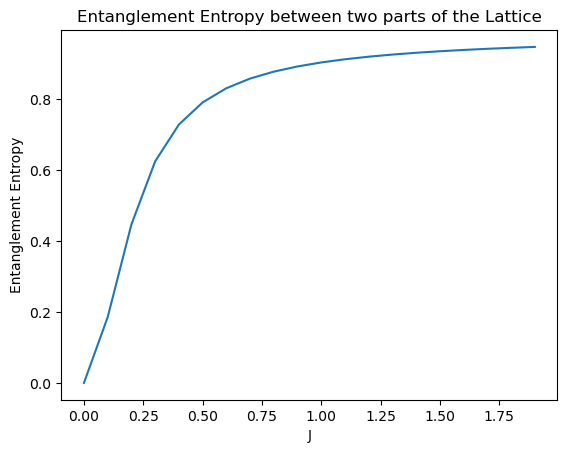

In [51]:
# Initial Script
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 2, 3, 3
params['hop_list'] = np.arange(0, 2, 0.1)
def plot_Bipartite_EntanglementEntropyVsJ(params, **kwargs):
    '''
    Returns plot of Bipartite Entanglement Entropy vs J for a constant U.
    '''
    entropy = []
    for t in params['hop_list']:
        S = 0
        params['t'] = t
        _, eigenvec = HamiltonianMatrix(params)
        ## For Sparse Matrices
        # trace_right_sites = density_reduced_dmatrix(params,eigenvec)
        # eigval_small, _ = sp.linalg.eigsh(trace_right_sites, k=trace_right_sites.shape[0]-1, which='SA')
        # eigL, _ = sp.linalg.eigsh(trace_right_sites, k=1, which='LA')
        # for e in np.concatenate((eigval_small, eigL)):
        #     if e>0:
        #         S+= (np.power(np.abs(e),2))*np.log(np.power(np.abs(e),2))
        
        ## For numpy arrays
        trace_right_sites = density_reduced_dmatrix(params,eigenvec)
        eig, _ = np.linalg.eig(trace_right_sites)
        for e in eig:
            if e>0:
                S+= e*np.log(e)
        
        entropy+=[-S]
    # print(entropy)
    plt.plot(params['hop_list'], entropy)
    plt.xlabel('J')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entanglement Entropy between two parts of the Lattice')
    plt.show()
        ## The lines of code below are used to visualize the Reduced Density Matrix for each t.
        # fig, axs = plt.subplots(1, figsize=(14, 6))
        # im = axs.imshow(trace_right_sites, cmap="Blues")
        # # axs.set_xlabel('Site i')
        # # axs.set_ylabel('Site j')
        # axs.set_title(f'Bipartite Entanglement at t = {t:.1f}, U={params["U"]}')
        # fig.colorbar(im, ax=axs, label = 'Correlation between two halves of the lattice')
    pass
plot_Bipartite_EntanglementEntropyVsJ(params)

In [29]:
0.43516215*0.78820544

0.34299717391209605

In [ ]:
# Initial Script
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2
params['hop_list'] = np.arange(0, 2, 0.1)
dimension(params)
def density_reduced_dmatrix(params, eigenvec, **kwargs):
    '''
    Initializes states_vec and store as params.
    ---------
    Returns reduced density matrix of left side of the lattice.
    '''
    S, entropy = 0,[]
    valid_combinations, _ = Prod_OccupBasis(params)
    n = params['truncationParam_n']+1
    particle_loc_list, states_lists, probamp_lists = [list(value) for value in valid_combinations.values()], [], []
    params['states_vec'] = np.array(particle_loc_list)
    center_index = params['N']//2
    ## Right-side has larger no. of Lattice sites. For eg. 5 lattice sites = 3R + 2L
    particle_loc_left_list = list(filter(lambda x: np.sum(x)<=params['k'], list(itertools.product(list(range(n)), repeat=(center_index)))))
    particle_loc_right_list = list(filter(lambda x: np.sum(x)<=params['k'], list(itertools.product(list(range(n)), repeat=params['N']-(center_index)))))
    left_side_states, right_side_states = np.array(particle_loc_left_list), np.array(particle_loc_right_list)
    left_side_length, right_side_length = left_side_states.shape[1], right_side_states.shape[1]
    trace_right_sites = sp.csc_matrix((left_side_states.shape[0], left_side_states.shape[0]))
    
    # Reduced Density Matrix of the left side of the lattice.
    # Trace out the right side of the lattice.
    for i, state1 in enumerate(params['states_vec']):
        for j, state2 in enumerate(params['states_vec']):
            if np.array_equal(state2[-right_side_length:],state1[-right_side_length:]) == True:
                states_lists.append([state1, state2])
                eg1, eg2 = eigenvec[i][0], np.conjugate(eigenvec[j][0])
                probamp_lists.append(eg1*eg2)
    # Finding the matrix elements of the RDM of Left side with respect to the elements of n_L
    for states, probamp in zip(states_lists, probamp_lists):
        state1, state2, prob_val = states[0], states[1], probamp
        for k, vec1 in enumerate(left_side_states):
            for h, vec2 in enumerate(left_side_states):
                if np.array_equal(vec1, state1[:left_side_length])==True and np.array_equal(vec2, state2[:left_side_length])==True: 
                    trace_right_sites[k, h] += prob_val
    # eigval_small, _ = sp.linalg.eigsh(trace_right_sites, k=trace_right_sites.shape[0]-1, which='SA')
    # eigL, _ = sp.linalg.eigsh(trace_right_sites, k=1, which='LA')
    # for e in np.concatenate((eigval_small, eigL)):
    #     if e>0:
    #         S+= e*np.log(np.power(np.abs(e),2))
        
    ## For numpy arrays
    trace_right_sites = density_reduced_dmatrix(params,eigenvec).toarray()
    eig, _ = np.linalg.eig(trace_right_sites)
    for e in eig:
        if e>0:
            S+= e*np.log(e)
        
    entropy+=[-S]
    print(entropy)
    return trace_right_sites # returns RDM of left side by ignoring right side.
_, eigenvec = HamiltonianMatrix(params)
trace_right_sites = density_reduced_dmatrix(params, eigenvec=normalizeWF(eigenvec)).toarray()  
print(trace_right_sites)
# print(np.sum(np.abs(eigenvec)))
# print(np.abs(eigenvec))
# _, eigenvec_Array = np.linalg.eig(H.toarray())
# eigenvec_Array1 = np.abs(np.array([eigenvec_Array[0]]).transpose())
# print(eigenvec_Array1)
# trace_right_sites = density_reduced_dmatrix(params, eigenvec=eigenvec_Array1).toarray()  

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [14]:
# Initial Script
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2
params['hop_list'] = np.arange(0, 2, 0.1)
params['t']= 1.5
dimension(params)
def density_reduced_dmatrix(params, eigenvec, **kwargs):
    '''
    Initializes states_vec and store as params.
    ---------
    Returns reduced density matrix of left side of the lattice.
    '''
    S, entropy = 0, []
    valid_combinations, _ = Prod_OccupBasis(params)
    n = params['truncationParam_n']+1
    particle_loc_list, states_lists, probamp_lists = [list(value) for value in valid_combinations.values()], [], []
    params['states_vec'] = np.array(particle_loc_list)
    center_index = params['N']//2
    ## Right-side has larger no. of Lattice sites. For eg. 5 lattice sites = 3R + 2L
    particle_loc_left_list = list(filter(lambda x: np.sum(x)<=params['k'], list(itertools.product(list(range(n)), repeat=(center_index)))))
    particle_loc_right_list = list(filter(lambda x: np.sum(x)<=params['k'], list(itertools.product(list(range(n)), repeat=params['N']-(center_index)))))
    left_side_states, right_side_states = np.array(particle_loc_left_list), np.array(particle_loc_right_list)
    left_side_length, right_side_length = left_side_states.shape[1], right_side_states.shape[1]
    trace_right_sites = sp.csc_matrix((left_side_states.shape[0], left_side_states.shape[0]))
    
    # Reduced Density Matrix of the left side of the lattice.
    # Trace out the right side of the lattice.
    for i, state1 in enumerate(params['states_vec']):
        for j, state2 in enumerate(params['states_vec']):
            if np.array_equal(state1[-right_side_length:], state2[-right_side_length:]) == True:
                eg1, eg2 = eigenvec[i][0], eigenvec[j][0]
                vec_left1, vec_left2 = state1[:left_side_length], state2[:left_side_length]
                kk = np.where(np.all(left_side_states == vec_left1, axis=1))[0]
                hh = np.where(np.all(left_side_states == vec_left2, axis=1))[0]
                for k in kk:
                    for h in hh:
                        trace_right_sites[k, h] += eg1*eg2
                        print(f'For (k,h)={k,h}, trace_right_sites[k, h]={trace_right_sites[k, h]}')
    eigval_small, _ = sp.linalg.eigsh(trace_right_sites, k=trace_right_sites.shape[0]-1, which='SA')
    eigL, _ = sp.linalg.eigsh(trace_right_sites, k=1, which='LA')
    for e in np.concatenate((eigval_small, eigL)):
        if e>0:
            S+= e*np.log(np.power(np.abs(e),2))
        
    ## For numpy arrays
    # trace_right_sites = density_reduced_dmatrix(params,eigenvec).toarray()
    # eig, _ = np.linalg.eig(trace_right_sites)
    # for e in eig:
    #     if e>0:
    #         S+= e*np.log(e)
        
    entropy+=[-S]
        
    return trace_right_sites # returns RDM of left side by ignoring right side.
_, eigenvec = HamiltonianMatrix(params)
trace_right_sites = density_reduced_dmatrix(params, eigenvec=normalizeWF(eigenvec)).toarray()  
# print(repr(trace_right_sites))
# print(np.sum(np.abs(eigenvec)))
# print(np.abs(eigenvec))
# _, eigenvec_Array = np.linalg.eig(H.toarray())
# eigenvec_Array1 = np.abs(np.array([eigenvec_Array[0]]).transpose())
# print(eigenvec_Array1)
# trace_right_sites = density_reduced_dmatrix(params, eigenvec=eigenvec_Array1).toarray()  

For (k,h)=(0, 0), trace_right_sites[k, h]=0.2089002531736607
For (k,h)=(1, 1), trace_right_sites[k, h]=0.5821994936526789
For (k,h)=(2, 2), trace_right_sites[k, h]=0.2089002531736606


For (k,h)=(0, 0), trace_right_sites[k, h]=1.1654908567993873e-32
For (k,h)=(1, 1), trace_right_sites[k, h]=0.9999999999999998
For (k,h)=(2, 2), trace_right_sites[k, h]=3.0317593685797633e-33
For (k,h)=(0, 0), trace_right_sites[k, h]=0.017880827278685205
For (k,h)=(1, 1), trace_right_sites[k, h]=0.9642383454426299
For (k,h)=(2, 2), trace_right_sites[k, h]=0.01788082727868511
For (k,h)=(0, 0), trace_right_sites[k, h]=0.05478279763924238
For (k,h)=(1, 1), trace_right_sites[k, h]=0.8904344047215152
For (k,h)=(2, 2), trace_right_sites[k, h]=0.05478279763924238
For (k,h)=(0, 0), trace_right_sites[k, h]=0.08995390008388003
For (k,h)=(1, 1), trace_right_sites[k, h]=0.8200921998322401
For (k,h)=(2, 2), trace_right_sites[k, h]=0.08995390008387999
For (k,h)=(0, 0), trace_right_sites[k, h]=0.11750026499920511
For (k,h)=(1, 1), trace_right_sites[k, h]=0.7649994700015902
For (k,h)=(2, 2), trace_right_sites[k, h]=0.11750026499920511
For (k,h)=(0, 0), trace_right_sites[k, h]=0.13819660112501048
For (k

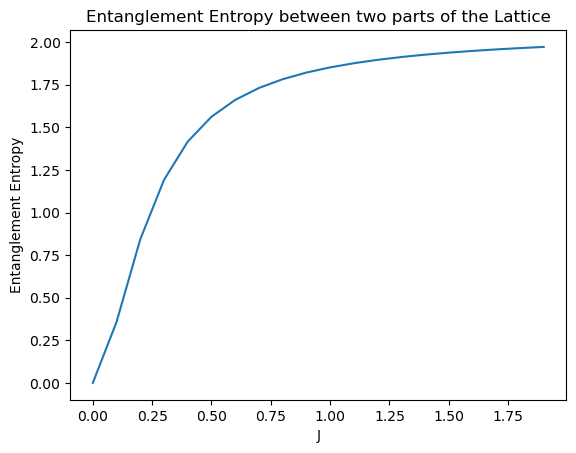

In [260]:
# Initial Script
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 3, 2, 2
params['hop_list'] = np.arange(0, 2, 0.1)

def plot_Bipartite_EntanglementEntropyVsJ(params, **kwargs):
    '''
    Returns plot of Bipartite Entanglement Entropy vs J for a constant U.
    '''
    entropy = []
    for t in params['hop_list']:
        S = 0
        params['t'] = t
        _, eigenvec = HamiltonianMatrix(params)
        ## For Sparse Matrices
        trace_right_sites = density_reduced_dmatrix(params,eigenvec)
        eigval_small, _ = sp.linalg.eigsh(trace_right_sites, k=trace_right_sites.shape[0]-1, which='SA')
        eigL, _ = sp.linalg.eigsh(trace_right_sites, k=1, which='LA')
        for e in np.concatenate((eigval_small, eigL)):
            if e>0:
                S+= e*np.log(np.power(np.abs(e),2))
        
        ## For numpy arrays
        # trace_right_sites = density_reduced_dmatrix(params,eigenvec).toarray()
        # eig, _ = np.linalg.eig(trace_right_sites)
        # for e in eig:
        #     if e>0:
        #         S+= e*np.log(e)
        
        entropy+=[-S]
    print(entropy)
    plt.plot(params['hop_list'], entropy)
    plt.xlabel('J')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entanglement Entropy between two parts of the Lattice')
    plt.show()
        ## The lines of code below are used to visualize the Reduced Density Matrix for each t.
        # fig, axs = plt.subplots(1, figsize=(14, 6))
        # im = axs.imshow(trace_right_sites, cmap="Blues")
        # # axs.set_xlabel('Site i')
        # # axs.set_ylabel('Site j')
        # axs.set_title(f'Bipartite Entanglement at t = {t:.1f}, U={params["U"]}')
        # fig.colorbar(im, ax=axs, label = 'Correlation between two halves of the lattice')
    return trace_right_sites
    # pass
trace_right_sites = plot_Bipartite_EntanglementEntropyVsJ(params)

In [3]:
arr = np.random.rand(2, 3, 4, 5) 
print(arr)

[[[[0.33954036 0.31576308 0.65634613 0.14764642 0.11936009]
   [0.38110012 0.49739628 0.84234473 0.1935324  0.68076488]
   [0.1350189  0.30065536 0.02720104 0.34686825 0.86867676]
   [0.40208272 0.79501432 0.21495111 0.76651393 0.14291946]]

  [[0.04147684 0.31618859 0.39826581 0.08376337 0.09690275]
   [0.76836486 0.83726304 0.95286588 0.15562007 0.59694825]
   [0.75019614 0.87581817 0.96463654 0.93582208 0.36166589]
   [0.35695974 0.70603064 0.88135897 0.55130385 0.5467049 ]]

  [[0.18853674 0.98063063 0.39964518 0.6986449  0.32537359]
   [0.42920024 0.86510868 0.56612742 0.05730261 0.13384456]
   [0.81610011 0.82685351 0.99438356 0.81931078 0.41446423]
   [0.39740604 0.9165831  0.1124612  0.52805963 0.2025249 ]]]


 [[[0.57287191 0.27160183 0.47539573 0.67051522 0.52525072]
   [0.76134242 0.31830411 0.45022615 0.84546918 0.11993888]
   [0.21275065 0.3595732  0.64977219 0.1583545  0.31448618]
   [0.51964663 0.0247293  0.40612851 0.42488238 0.48003478]]

  [[0.46831575 0.08391604 0.44